In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mplt
from matplotlib import rcParams
from matplotlib import rc
import glob
rc('mathtext', default='regular') 
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
rcParams['font.size'] = 12

### The following code was used to determine when the syndromic surveillance (ESSENCE) reporting system was down for each facility
#### We cannot use the periods where the system was offline as a referent period because there would be false 0's in our case-crossover dataset where the system was down rather than there actually not being a patient reported

In [2]:
# we have a file for every NM facility and their daily reports
# read in all the facilities and make one large dataset
inputfiles = glob.glob('C:/Users/olivia.sablan/OneDrive - State of New Mexico/Documents/Data/health/ESSENCE Facilities/*.csv')
df_from_each_file = (pd.read_csv(f) for f in inputfiles)
essence = pd.concat(df_from_each_file, sort = False)
# Get a daily sum of the total ESSENCE reports per facility
essence = essence.groupby(by = ['Date',  'Facility', 'Facility Name']).sum().reset_index()
essence["Date"] = pd.to_datetime(essence['Date'], utc = True)

In [3]:
# We have one large file for all NM emergency departments facilities and their total visits
# Read in this file and convert the datet to a pandas datetime
ED = pd.read_csv('C:/Users/olivia.sablan/OneDrive - State of New Mexico/Documents/Data/health/ED/ED_countbyfacility.csv')
ED['date_of_visit'] = pd.to_datetime(ED['date_of_visit'])
ED = ED.rename(columns = {'date_of_visit': "Date"})
ED['Date'] = pd.to_datetime(ED['Date'], utc = True)

In [4]:
# This is another dataset that has all of the NM facilities and their ID number as well as facility name
# We need to read it in to merge these two datasets
IDs = pd.read_csv('C:/Users/olivia.sablan/OneDrive - State of New Mexico/Documents/Data/health/ESSENCE Facilities/Graphs/FacilityNameID.csv')
# Merge this new dataset with the names and ID numbers with the ED visits
merged = pd.merge(ED, IDs[['Facility', 'Facility Name', 'NMStateLicenseNum']], on = 'NMStateLicenseNum')
# Then merge with the large dataset with essence
mergedall = pd.merge(merged, essence[['Date', 'Facility Name', 'Data']], on = ['Date', 'Facility Name'])
mergedall['Facility'] = mergedall['Facility'].astype('float')

# Make a list of all the facility names in NM
FN = mergedall['Facility Name'].unique()
# We need to remove the facilities that we deemed to be completely online through the whole study (2019-2022), so that we are only looking for offline periods in facilities that for sure went offline
OnlineOnly = FN[1], FN[2], FN[4], FN[6], FN[8], FN[9], FN[10], FN[11], FN[13], FN[14], FN[15], FN[16],  FN[17], FN[18], FN[19], FN[21], FN[22], FN[23], FN[24], FN[28], FN[30], FN[33], FN[34], FN[35]
OfflineFacilites= mergedall['Facility Name'][~mergedall['Facility Name'].isin(OnlineOnly)].unique()

# Rename some columns so we can keep things straight
mergedall = mergedall.rename(columns = {'n':'DailyEDVisits', 'Data':'DailyESSENCE'})

In [5]:
# Make a column where we can flag when the ESSENCE system was down
# We determined that (for the most part) when there were 2 times as many ED visits in a day than there were ESSENCE reports, the ESSENCE system for that facility was down
mergedall['Flag'] = np.where((mergedall['Facility Name'].isin(OfflineFacilites)) & (mergedall['DailyEDVisits'] > mergedall['DailyESSENCE'] * 2), 0, 1)
IDnum = mergedall['Facility'].unique()
print('Percentage of facilities online the whole time: ', round(len(OnlineOnly)/len(IDnum) *100, 2))

Percentage of facilities online the whole time:  66.67


In [6]:
# Make a dataframe that only has the dates where EVERY facility was online (this is all dates for the Facilities we separated out above)
ONLINEdates = mergedall[['Date', 'Facility Name', 'NMStateLicenseNum']][mergedall['Flag'] == 1]
ONLINEdates['Date'] = ONLINEdates['Date'].dt.date
ONLINEdates.to_csv('../Data/health/ESSENCE Facilities/ONLINEdates.csv')

In [7]:

print('Percentage of data that is offline for the facilities that go offline: ',round(len(mergedall[mergedall['Flag'] == 0])/len(mergedall) *100, 1))

Percentage of data that is offline for the facilities that go offline:  9.0


##### The remaining code was used to determine if our method of finding offline periods was adequate

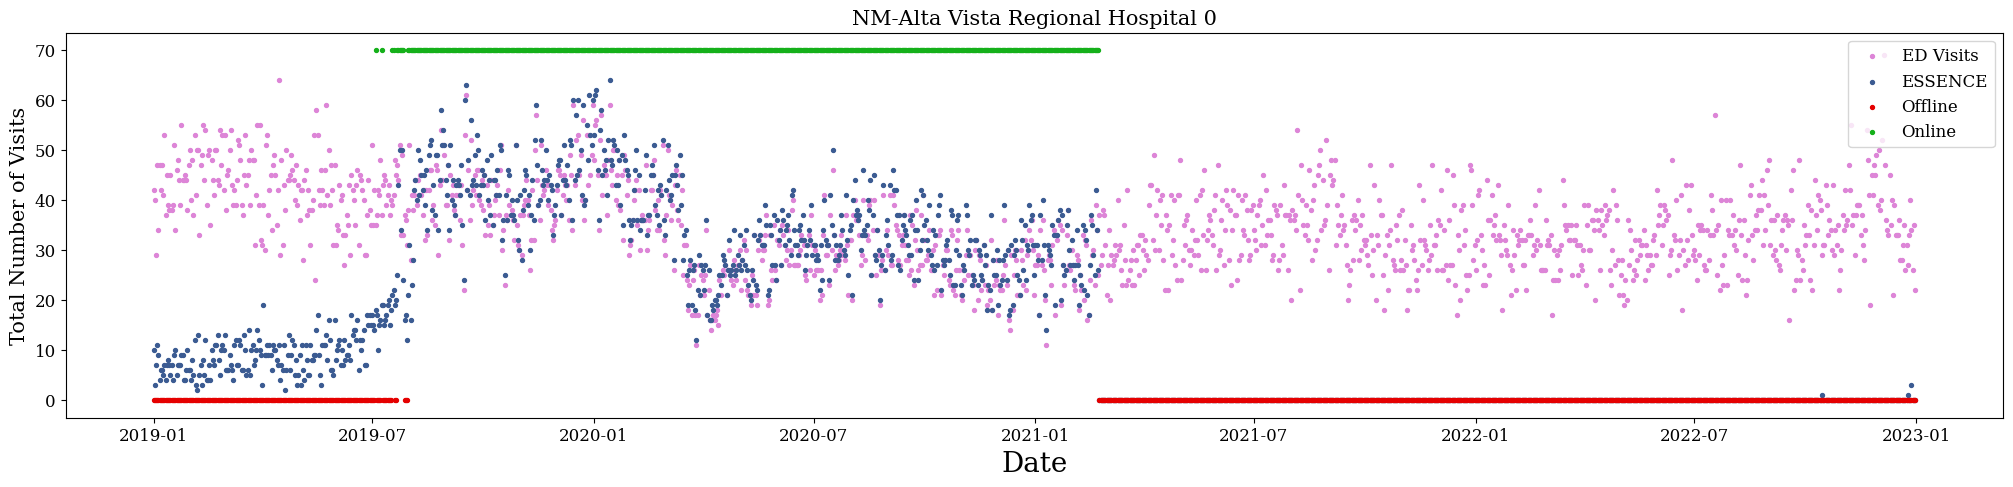

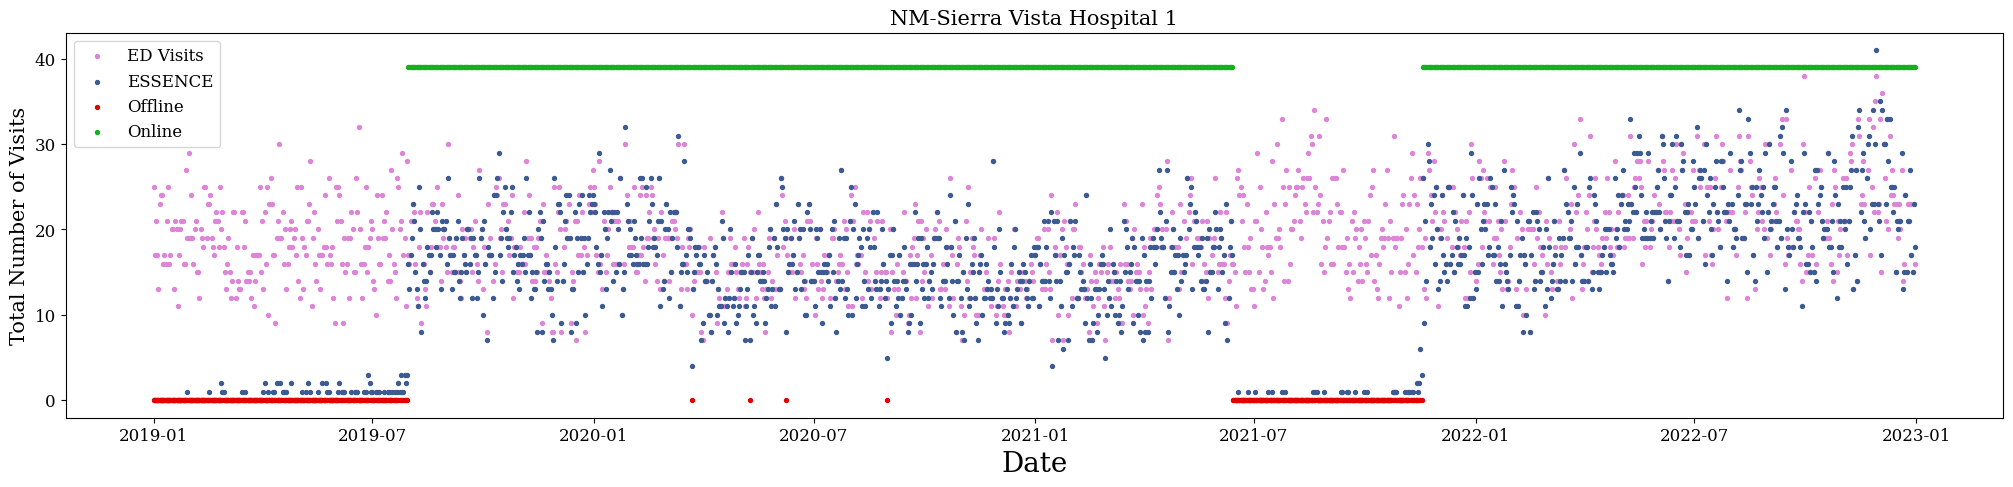

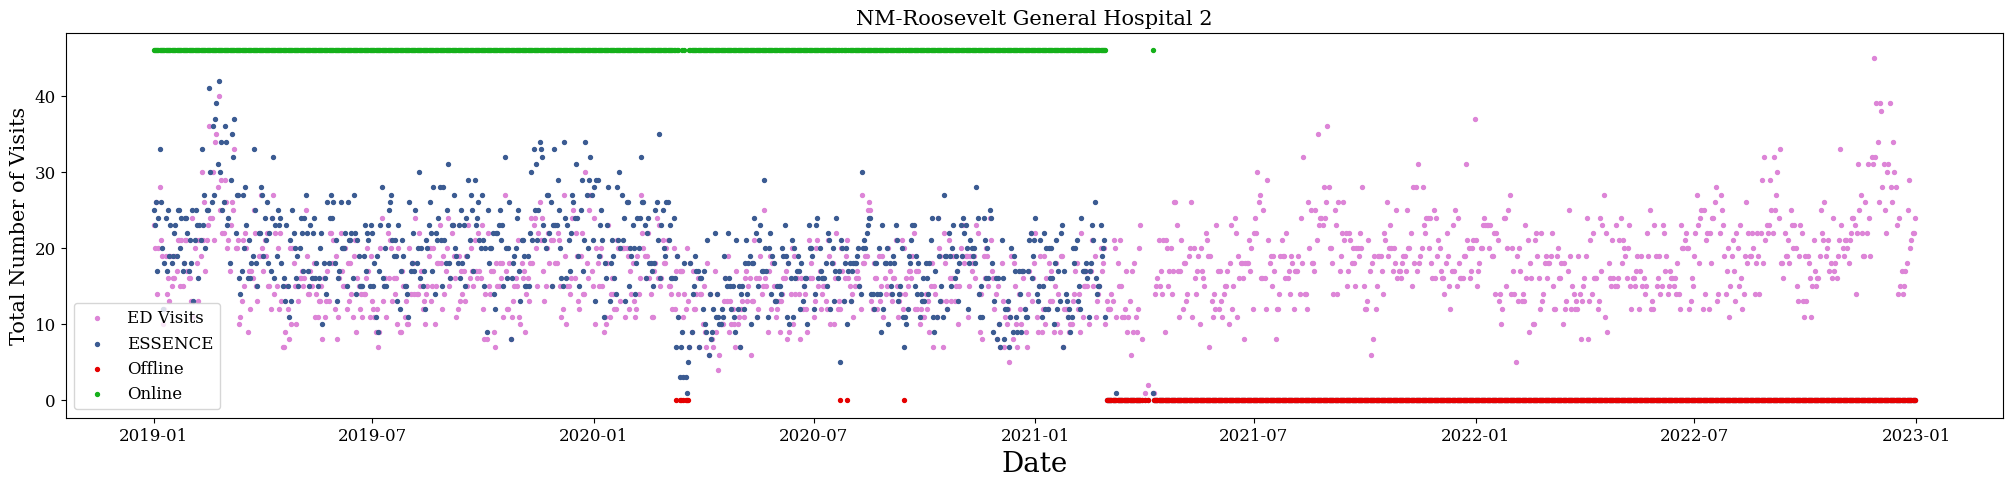

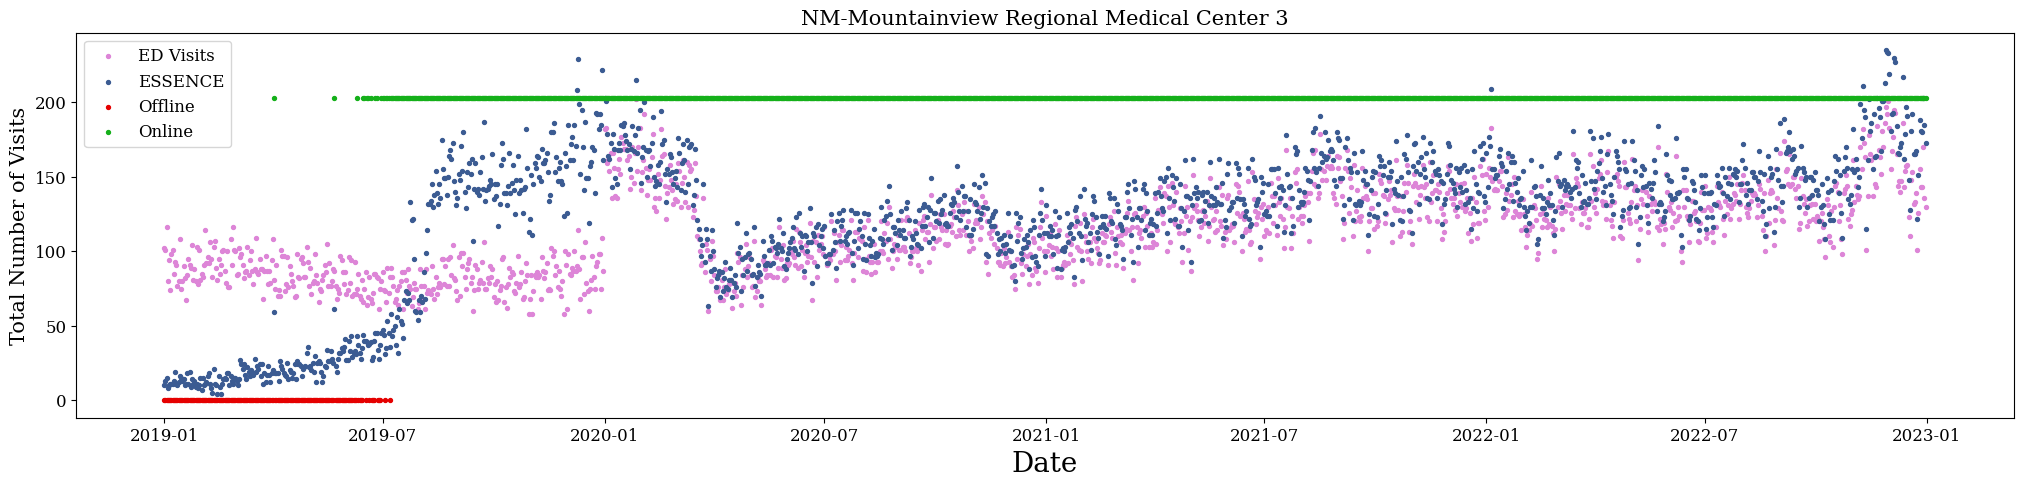

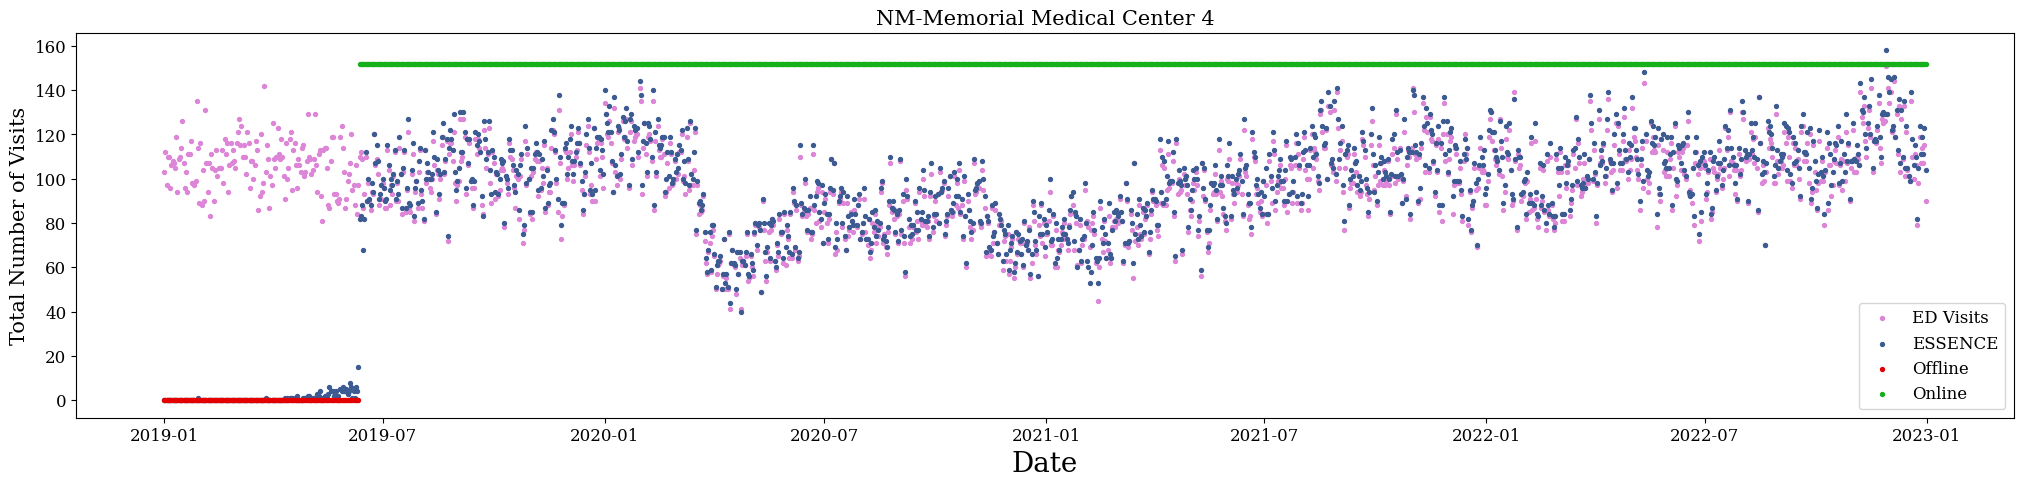

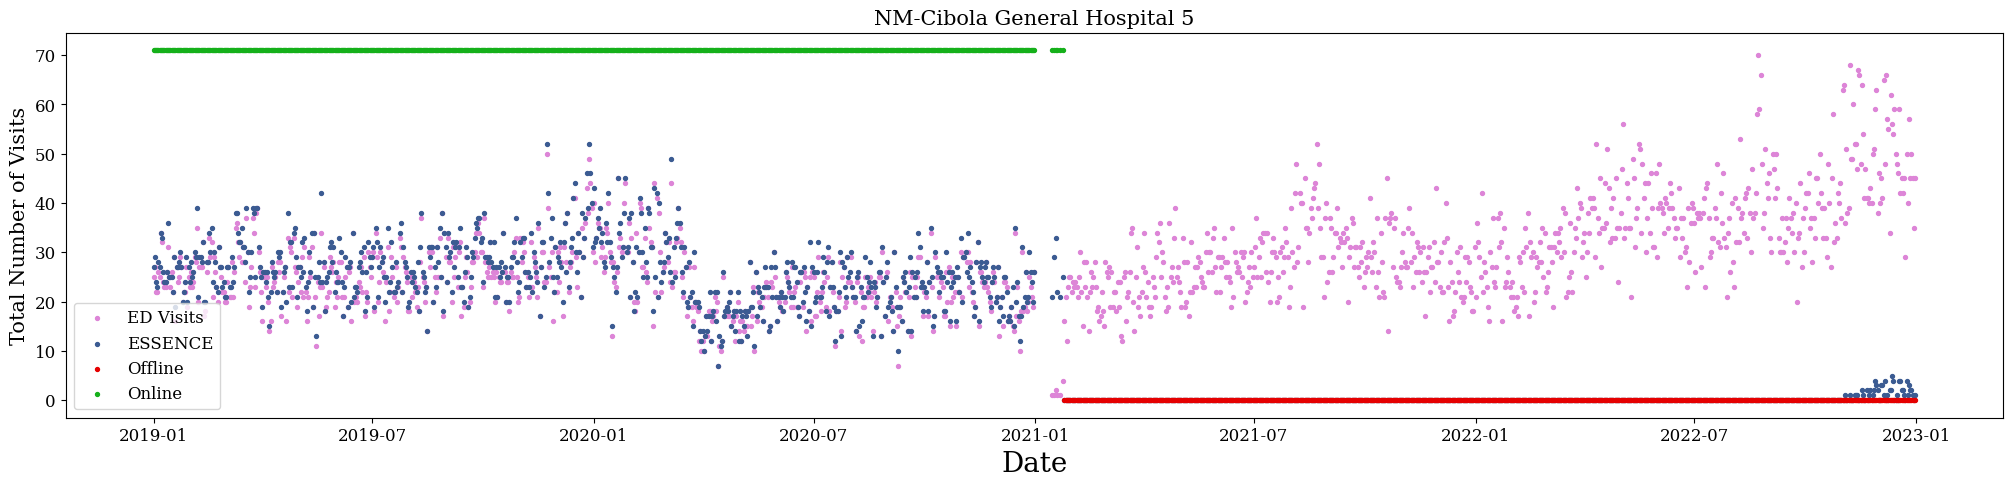

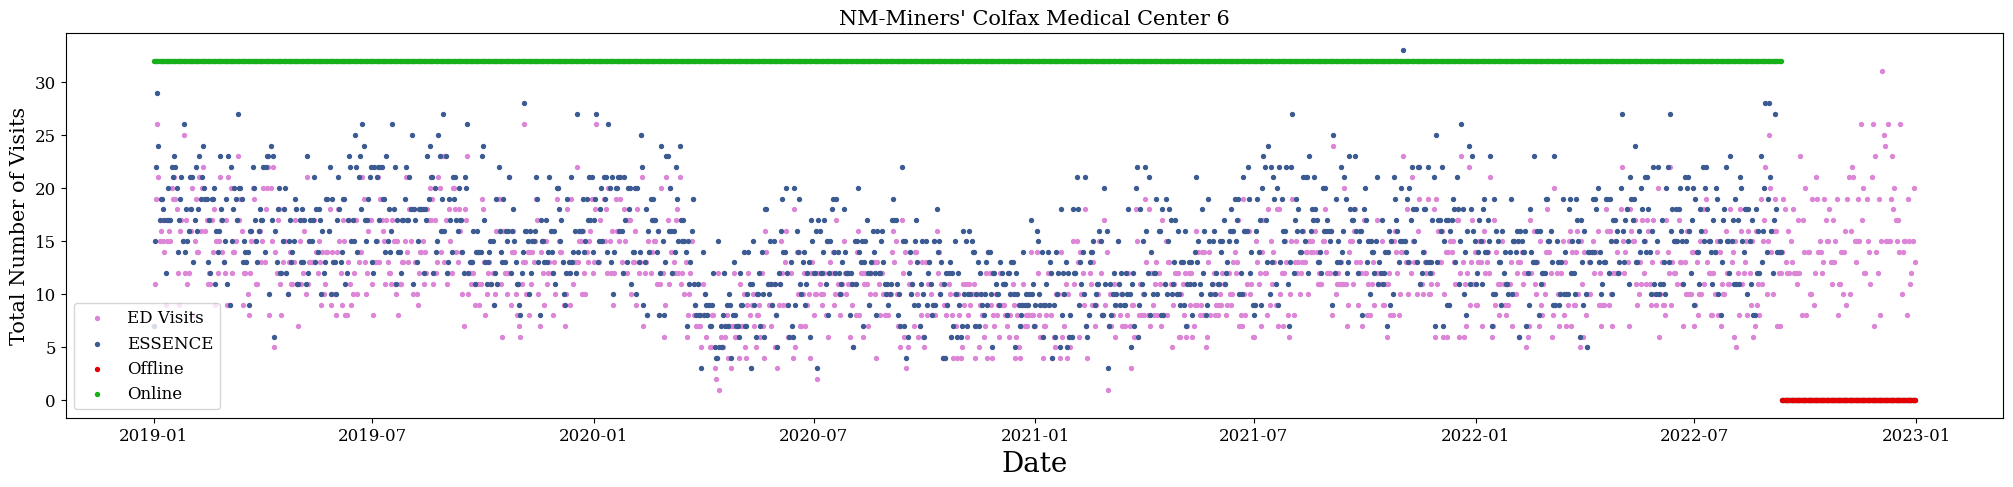

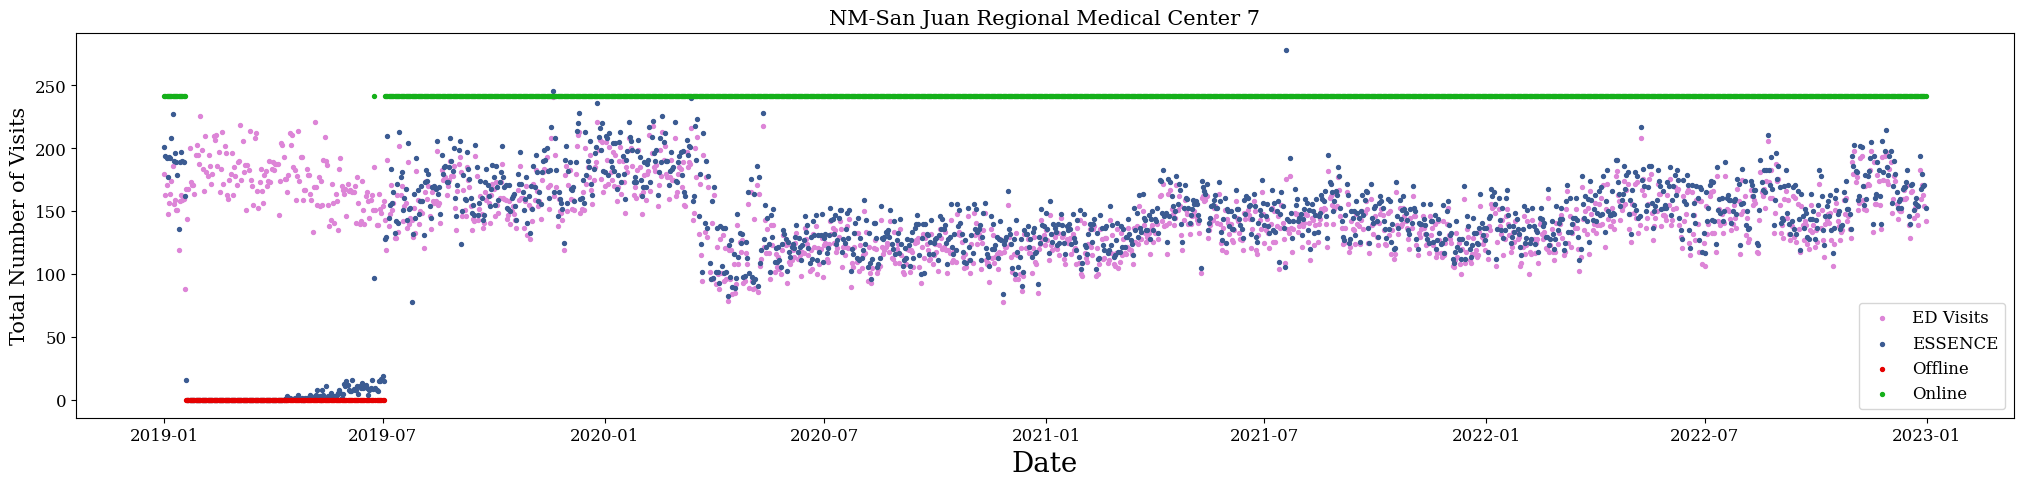

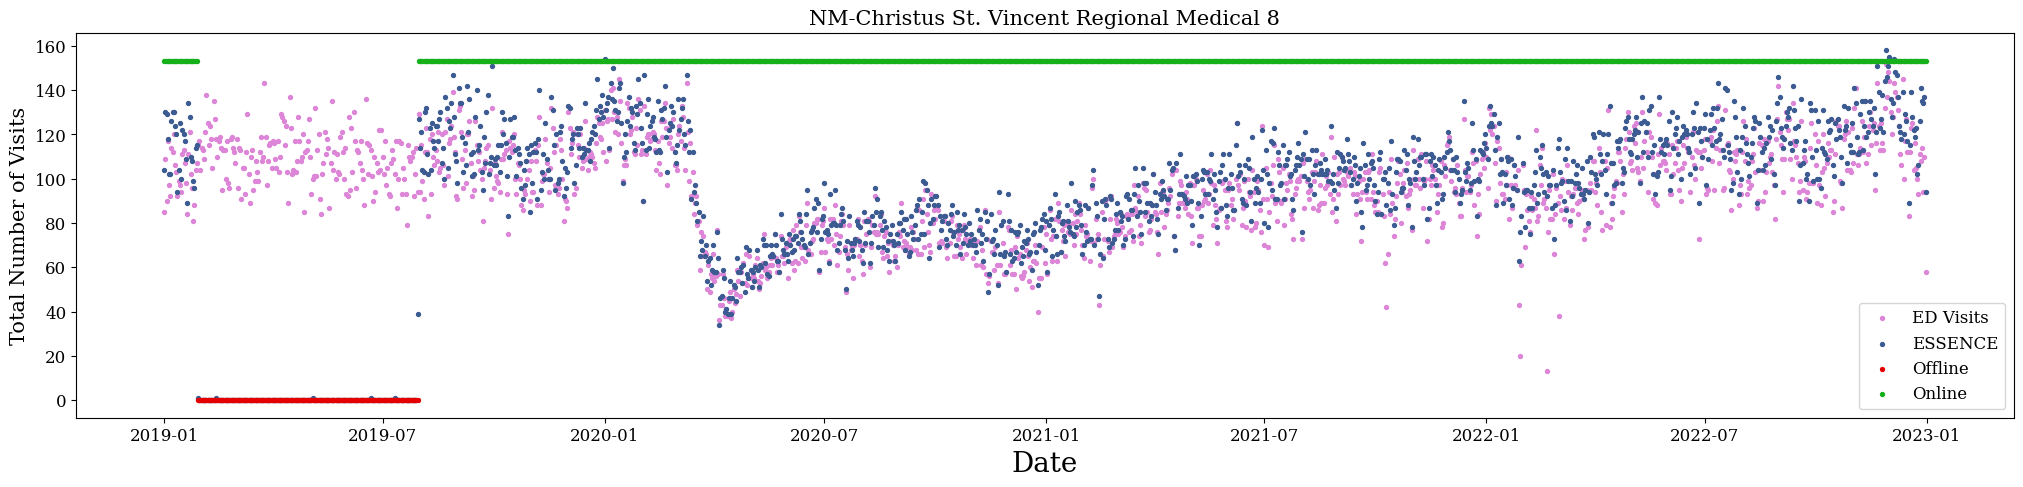

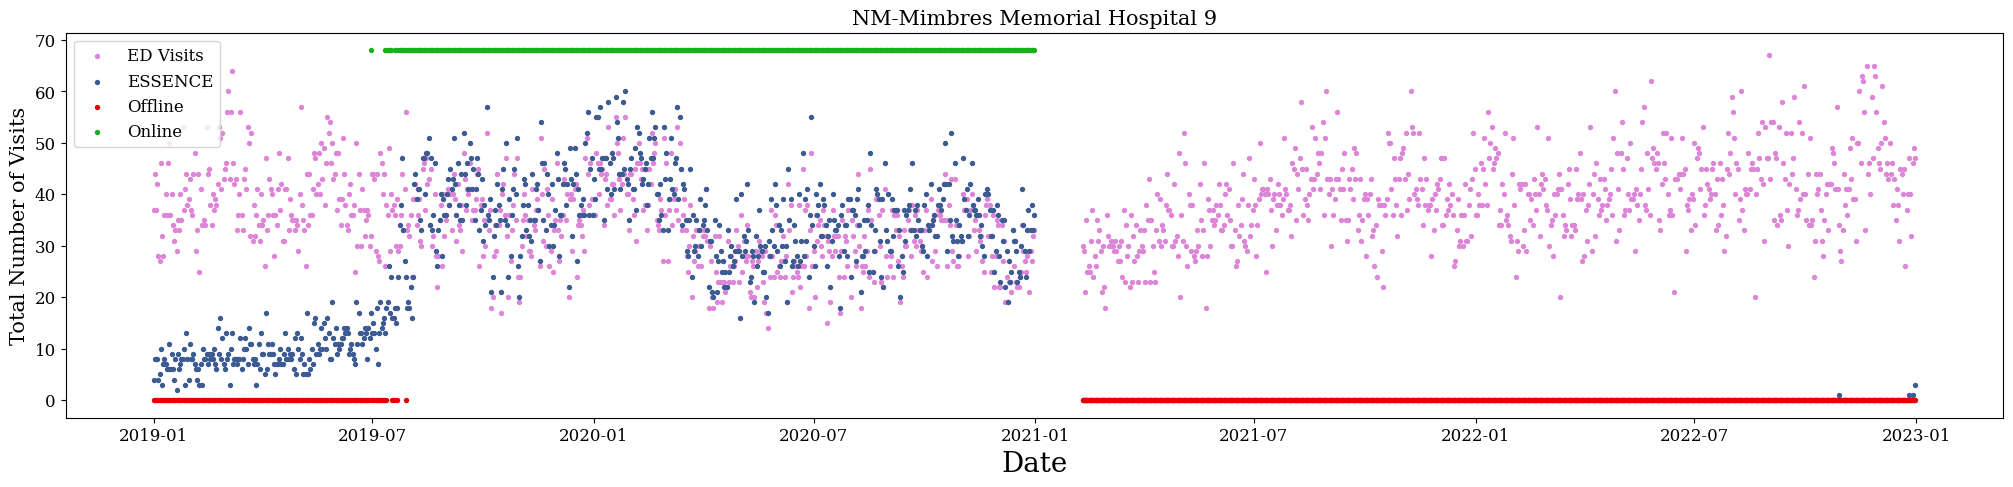

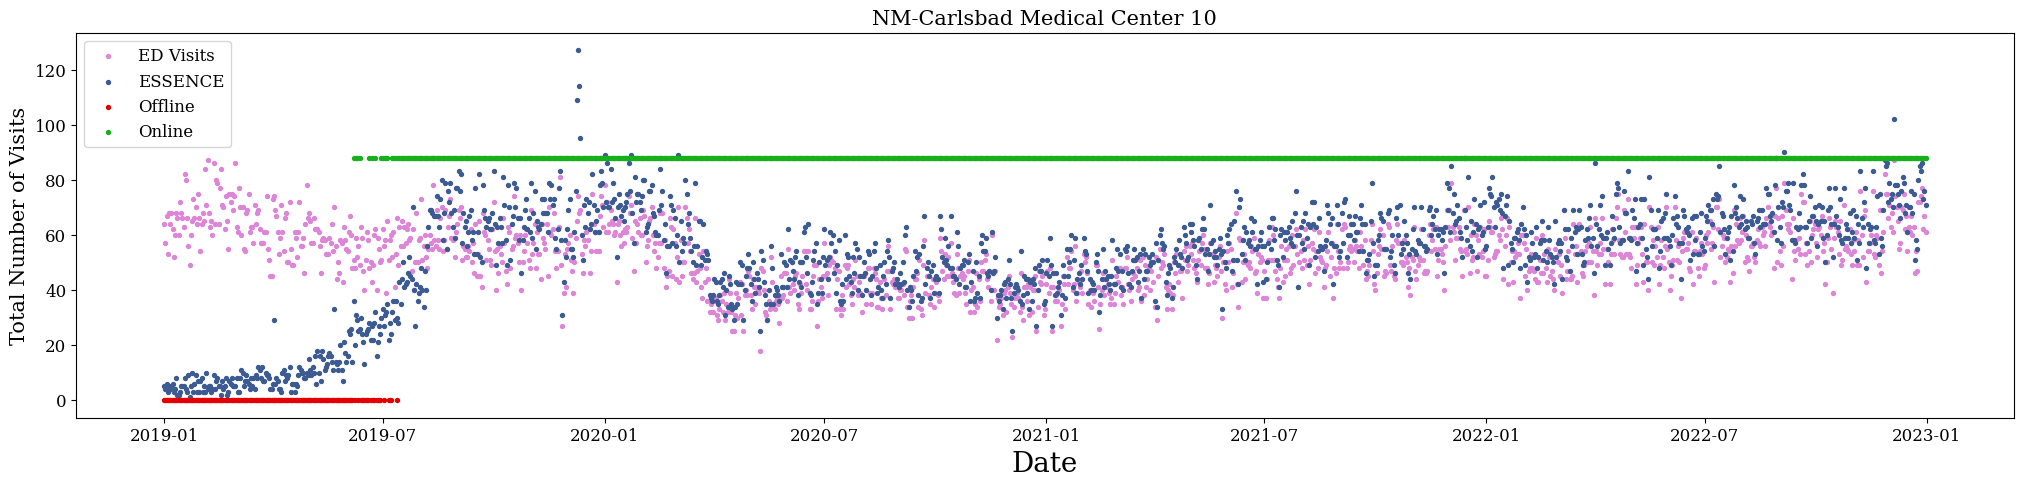

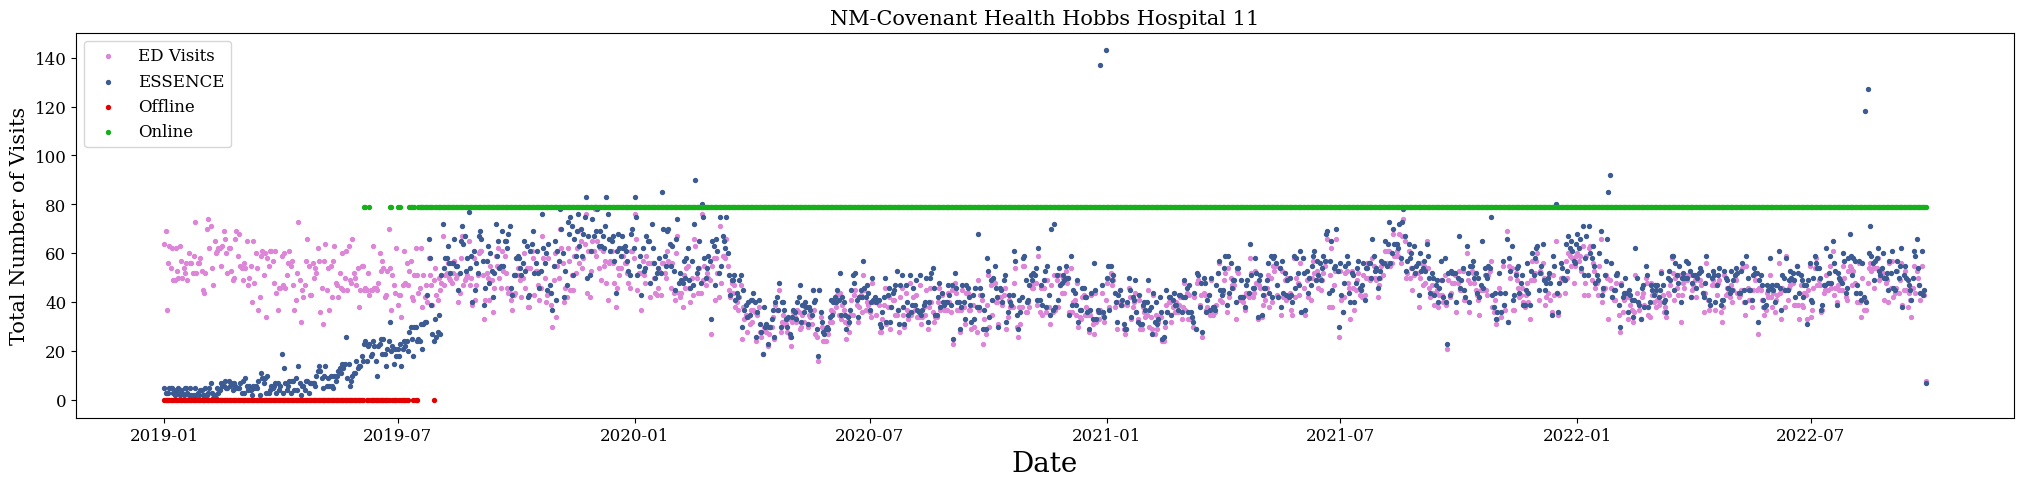

In [14]:
for i in range(len(OfflineFacilites)):
    onefac = mergedall[mergedall['Facility Name'] == OfflineFacilites[i]]
    off = onefac[onefac['Flag'] == 0]
    on = onefac[onefac['Flag'] == 1]
    fig, ax = plt.subplots(figsize = (25, 5))
    ax.scatter(onefac['Date'], onefac['DailyEDVisits'], s = 8, color = 'xkcd:lavender pink', label = 'ED Visits')
    ax.scatter(onefac['Date'], onefac['DailyESSENCE'], s = 8, color = 'xkcd:denim blue', label = 'ESSENCE')
    ax.scatter(off['Date'], off['Flag'], s = 8, color = 'xkcd:red', label = 'Offline')
    ax.scatter(on['Date'], on['Flag'] + np.max(onefac['DailyEDVisits']), s = 8, color = 'xkcd:green', label = 'Online')
    ax.set_ylabel('Total Number of Visits', fontsize = 15)
    ax.set_xlabel('Date', fontsize = 20)
    ax.set_title(str(onefac['Facility Name'].iloc[0] + ' ' +  str(i)), fontsize = 15)
    ax.legend()
    plt.show()
    fig.savefig('../Figures/totalESSENCE/OfflinePeriods/' + onefac['Facility Name'].iloc[0] + '.png', dpi = 200, bbox_inches = 'tight')